In [31]:
import pymongo
import matplotlib as mpl
mpl.use('pdf')
import matplotlib.pyplot as plt
from bson.son import SON
import pandas as pd

%matplotlib inline  

C:\Users\nicok\Miniconda3\envs\asl\lib\site-packages\ipykernel_launcher.py:3: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
from datetime import datetime, timedelta

time_str = '11:10:20.242'
time_str = 'get'
datetime_str = f'01.01.1900-{time_str}'

format_str = '%d.%m.%Y-%H:%M:%S.%f'

d = datetime.strptime(datetime_str, format_str)

d2 = d + timedelta(seconds=10)
d3 = d + timedelta(milliseconds=10)
print(d)
print(d2)
print(d3)

ValueError: time data '01.01.1900-get' does not match format '%d.%m.%Y-%H:%M:%S.%f'

In [5]:
ip = "localhost"
port = "27017"

info = {
    'experiment_suite_id' : 'mw_base'
}

client = pymongo.MongoClient(f"mongodb://{ip}:{port}/")

db = client[info['experiment_suite_id']]
results = db.collection['results']



In [91]:
doc = {
   "exp":"exp31",
   "mw_stats":[
      {
          "id": "mw00",
          "ops":[
             {"type": "set", "value": 5},
             {"type": "get", "value": 7}    
          ]
      },
        {
          "id": "mw00",
          "ops":[
             {"type": "set", "value": 5},
             {"type": "get", "value": 7}    
          ]
      }
   ]
}

demo_db = client['test']
demo_r = demo_db.collection['xy']

demo_r.insert(doc)

C:\Users\nicok\Miniconda3\envs\asl\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: insert is deprecated. Use insert_one or insert_many instead.


ObjectId('5bd375607566de5374f33922')

In [95]:

pipeline=[{"$unwind":"$mw_stats"}]
for x in demo_r.aggregate(pipeline):
    print(x)

{'_id': ObjectId('5bd375607566de5374f33922'), 'exp': 'exp31', 'mw_stats': {'id': 'mw00', 'ops': [{'type': 'set', 'value': 5}, {'type': 'get', 'value': 7}]}}


In [62]:
from datetime import datetime

datetime_object = datetime.strptime('19:28:13.451'.split(".")[0], '%H:%M:%S')

print(datetime_object)

1900-01-01 19:28:13


In [77]:
d = {'count': 8, 
'rt_arr2': [
{'m2': '667.0406249999994', 'mean': '1.2281250000000015', 'count': '960'}, 
{'m2': '1236.5497326203222', 'mean': '1.300534759358289', 'count': '935'}, 
{'m2': '898.9821428571427', 'mean': '1.3080357142857142', 'count': '896'}, 
{'m2': '631.1030368763547', 'mean': '1.2548806941431647', 'count': '922'}, 
{'m2': '583.0053821313236', 'mean': '1.2744886975242187', 'count': '929'}, 
{'m2': '837.7720979765719', 'mean': '1.228966986155485', 'count': '939'}, 
{'m2': '675.9903846153846', 'mean': '1.2467948717948716', 'count': '936'}, 
{'m2': '634.7920585161966', 'mean': '1.2173458725182873', 'count': '957'}
], 
'throughput': 1494.8, 
'slot': '17:10:23', 
'workload_ratio': '0:1', 
'ops_type': 'get', 
'n_worker_per_mw': 8, 
'n_vc': 1, 
'rep': 0, 

'rt_m2': {'mean': 1.2568905539202568, 'count': 7474, 'm2': 7475.716301065702}
    
}

count_a = 0
m2_a = 0.0
mean_a = 0.0
for b in d['rt_arr2']:
    count_b = int(b['count'])
    m2_b = float(b['m2'])
    mean_b = float(b['mean'])
    
    delta = mean_b - mean_a
    
    mean_a = mean_a + delta * count_b / (count_a + count_b)
    
    m2_a = m2_a + m2_b + delta**2 * count_a * count_b / (count_a + count_b)
    count_a += count_b
   
    
print(f"Count={count_a}, M2={m2_a}, Mean={mean_a}")

Count=7474, M2=6172.770136473107, Mean=1.2568905539202568


In [91]:
df.to_csv("./test.csv")

In [90]:
#for res in results.find():
 #   print(res)
    #print(res['mw_stats'][0]['ops'])
  #  break

from datetime import datetime
from datetime import timedelta

exp = "exp31"
n_vc = 32
workload = "write-only"
n_worker_per_mw = 64

t = {
    "write-only": "1:0",
    "read-only": "0:1"
}

pipeline = [
        {"$match": {"exp": exp,
                    "exp_config.n_vc" : n_vc, 
                    "exp_config.workload_ratio" : t[workload], 
                    "exp_config.n_worker_per_mw" : n_worker_per_mw}},
        {"$project":{"client_stats":0}},
        {"$unwind" : "$mw_stats"},
        {"$project":{"mw_stats.out":0, "exp_config":0}},
        {"$unwind":"$mw_stats.ops"},
        {"$match": {"mw_stats.ops.type": "set"}},
        {"$addFields": {"time": { "$dateFromString": {
                                     "dateString": {"$concat" : ["01.01.1900-", "$mw_stats.ops.time"]},
                                     "format": "%d.%m.%Y-%H:%M:%S.%L"}}
                     }},
        #{"$project": {"minutes": {"$minute":"$time"}, "seconds": {"$second":"$time"}}},
        {"$addFields": {"x": {"$toInt": "$mw_stats.ops.rt_count"}}},
        {"$group": {"_id" : {"min": {"$minute":"$time"}, "sec":{"$second":"$time"}, "rep":"$repetition"}, 
                   "count" : {"$sum" :  1},
                   "sum_rt_count" : {"$sum": "$x"}
                   }
               },
        {"$addFields": {"throughput": {"$divide" : ["$sum_rt_count", 5.0]}}},
        {"$sort":SON([("_id.rep",1), ("_id.min", 1), ("_id.sec", 1)])},
        #{"$group":{"_id" : {""}}}
    ]

pipeline3 = [
        {"$match": {"exp": exp,
                    "exp_config.n_vc" : n_vc, 
                    "exp_config.workload_ratio" : t[workload], 
                    "exp_config.n_worker_per_mw" : n_worker_per_mw}},
        {"$project":{"client_stats":1}}
    ]

pipeline2 = [
        {"$match": {"exp": exp}},
        {"$unwind":"$mw_stats"},
        {"$unwind":"$mw_stats.ops"},
        {"$addFields": {"time": { "$dateFromString": {
                                     "dateString": {"$concat" : ["01.01.1900-", "$mw_stats.ops.time"]},
                                     "format": "%d.%m.%Y-%H:%M:%S.%L"}}}
        },  # TODO [nku] remove when slot is here
        {"$addFields": {"slot": {"$concat" : [{"$toString":{"$hour":"$time"}}, 
                                                  ":",{"$toString":{"$minute":"$time"}}, 
                                                  ":", {"$toString":{"$second":"$time"}}]}}
        },  # TODO [nku] remove when slot is here
        {"$group": {"_id" : {"slot": "$slot", 
                             "workload_ratio": "$exp_config.workload_ratio",
                             "ops_type": "$mw_stats.ops.type",
                             "n_worker_per_mw": "$exp_config.n_worker_per_mw",
                             "n_vc": "$exp_config.n_vc",
                             "rep":"$repetition"}, 
                   "count" : {"$sum" :  1},
                   "sum_rt_count" : {"$sum": {"$toInt": "$mw_stats.ops.rt_count"}}, # TODO [nku] remove to int
                   "rt_arr" : {"$push": {"m2":"$mw_stats.ops.rt_m2", "mean":"$mw_stats.ops.rt_mean", "count":"$mw_stats.ops.rt_count"}},
                   "qwt_arr" : {"$push": {"m2":"$mw_stats.ops.qwt_m2", "mean":"$mw_stats.ops.qwt_mean", "count":"$mw_stats.ops.qwt_count"}},
                   "ntt_arr" : {"$push": {"m2":"$mw_stats.ops.ntt_M2", "mean":"$mw_stats.ops.ntt_mean", "count":"$mw_stats.ops.ntt_count"}},
                   "wtt_arr" : {"$push": {"m2":"$mw_stats.ops.wtt_M2", "mean":"$mw_stats.ops.wtt_mean", "count":"$mw_stats.ops.wtt_count"}},
                   }
        },
        {"$addFields":{ "rt": {"$reduce": reduce_stat("rt_arr")},
                        "qwt": {"$reduce": reduce_stat("qwt_arr")},
                        "ntt": {"$reduce": reduce_stat("ntt_arr")},
                        "wtt": {"$reduce": reduce_stat("wtt_arr")}
                     }
        },
        {"$addFields": {"throughput": {"$divide" : ["$sum_rt_count", 5.0]},
                        "rt_mean" : "$rt.mean",
                        "rt_std":{"$sqrt": {"$divide": ["$rt.m2", {"$subtract":["$rt.count", 1]}]}},
                        "qwt_mean" : "$qwt.mean",
                        "qwt_std":{"$sqrt": {"$divide": ["$qwt.m2", {"$subtract":["$qwt.count", 1]}]}},
                        "ntt_mean" : "$ntt.mean",
                        "ntt_std":{"$sqrt": {"$divide": ["$ntt.m2", {"$subtract":["$ntt.count", 1]}]}},
                        "wtt_mean" : "$wtt.mean",
                        "wtt_std":{"$sqrt": {"$divide": ["$wtt.m2", {"$subtract":["$wtt.count", 1]}]}},    
                       }},
        {"$project": {"_id": 0,
                        "slot": "$_id.slot",
                        "workload_ratio": "$_id.workload_ratio",
                        "ops_type": "$_id.ops_type",
                        "n_worker_per_mw": "$_id.n_worker_per_mw",
                        "n_vc": "$_id.n_vc",
                        "rep": "$_id.rep",
                        "count": 1,
                        "throughput":1,
                        "rt_mean" : 1,
                        "rt_std":1,
                        "qwt_mean" : 1,
                        "qwt_std":1,
                        "ntt_mean" : 1,
                        "ntt_std":1,
                        "wtt_mean" : 1,
                        "wtt_std": 1
                     }
        },
        {"$sort":SON([("workload_ratio",1),("n_worker_per_mw",1),("n_vc", 1), ("rep",1), ("slot", 1)])},
    ]



cursor = results.aggregate(pipeline2, allowDiskUse=True)
df =  pd.DataFrame(list(cursor))

print(df)

raise ValueError("xy")


result = {
        'slot' : [], 
        'throughput_rep0': [], 
        'throughput_rep1': [],
        'throughput_rep2': []
    }

slot = 0
for d in results.aggregate(pipeline3):
    print(d)
    
    continue
    rep = d['_id']['rep']
    result[f"throughput_rep{rep}"].append(d['throughput'])
    
    if rep == 0:
        result["slot"].append(slot)
        slot += 1

        

fig, ax = plt.subplots()
fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)

ax.set_xlim(0, result['slot'][-1])
ax.set_ylim(0, max(result['throughput_rep2'])+1000)

plt.plot(result['slot'][1:], result['throughput_rep0'][1:])
plt.plot(result['slot'][1:], result['throughput_rep1'][1:])
plt.plot(result['slot'][1:], result['throughput_rep2'][1:-1])


plt.show()
print(result)

      count  n_vc  n_worker_per_mw  ntt_mean   ntt_std ops_type  qwt_mean  \
0         8     1                8  0.015922  0.229354      get  0.092721   
1         8     1                8  0.000000 -0.000000     mget  0.092721   
2         8     1                8  0.000000 -0.000000      set  0.092721   
3         8     1                8  0.012486  0.195790      get  0.083805   
4         8     1                8  0.000000 -0.000000     mget  0.083805   
5         8     1                8  0.000000 -0.000000      set  0.083805   
6         8     1                8  0.011962  0.160475      get  0.076166   
7         8     1                8  0.000000 -0.000000     mget  0.076166   
8         8     1                8  0.000000 -0.000000      set  0.076166   
9         8     1                8  0.008078  0.151307      get  0.080351   
10        8     1                8  0.000000 -0.000000     mget  0.080351   
11        8     1                8  0.000000 -0.000000      set  0.080351   

ValueError: xy

In [81]:
def reduce_stat(arr):
    d = {"input": {"$filter": {"input": f"${arr}",
                                                                    "as":"x",
                                                                    "cond":{"$gt":[{"$toInt":"$$x.count"}, 0.0]}
                                                                   }
                                                       },
                                            "initialValue": {"mean": 0.0,
                                                             "count": 0,
                                                             "m2":0.0},
                                            "in": {"mean":{"$sum":["$$value.mean", 
                                                                    {"$multiply":[{"$subtract": [{"$toDouble":"$$this.mean"}, "$$value.mean"]}, 
                                                                                  {"$divide":[{"$toInt":"$$this.count"}, 
                                                                                              {"$sum":[{"$toInt":"$$this.count"},"$$value.count"]}]}
                                                                                 ]
                                                                    }
                                                                  ]},
                                                   "m2" : {"$sum" : ["$$value.m2", 
                                                                        {"$toDouble" : "$$this.m2"},
                                                                        {"$multiply": [
                                                                                        {"$pow":[
                                                                                            {"$subtract": [
                                                                                                {"$toDouble":"$$this.mean"}, 
                                                                                                "$$value.mean"]
                                                                                            }, 2]
                                                                                        },
                                                                                       {"$divide": [
                                                                                           {"$multiply": [
                                                                                               "$$value.count", 
                                                                                               {"$toInt":"$$this.count"}
                                                                                           ]},
                                                                                            {"$sum": [
                                                                                                "$$value.count", 
                                                                                                {"$toInt":"$$this.count"}
                                                                                            ]}
                                                                                       ]}
                                                                        ]}
                                                                  ]},
                                                   "count": {"$sum":["$$value.count", {"$toInt":"$$this.count"}]},
                                                  }
                                             }
    return d
    

In [ ]:
n_vc = [d['_id']['n_vc'] for d in res]
throughput = [d['ops/sec_avg'] for d in res]
e = [d['ops/sec_std'] for d in res]

plt.errorbar(n_vc, throughput, e, capsize=3)
#plt.axis([0, 35, 0, 1100])
plt.show()

In [50]:
def get_plot_data(workload, n_worker_per_mw=0):
    
    t = {
        "write-only": "1:0",
        "read-only": "0:1"
    }
    
    assert(workload in t)
    
    pipeline = [
        {"$match": {"exp_config.workload_ratio" : t[workload], "exp_config.n_worker_per_mw" : n_worker_per_mw}},
        {"$unwind" : "$client_stats"},
        {"$group" : {"_id" : {"_id" : "$_id",
                              "n_clients" : {"$multiply": ["$exp_config.n_client", 
                                                                                "$exp_config.n_instances_mt_per_machine", 
                                                                                "$exp_config.n_threads_per_mt_instance", 
                                                                                "$exp_config.n_vc"]}},
                     "client_throughput_sum" :{"$sum" :  "$client_stats.totals.Ops/sec"},
                     "client_response_time_sum" :{"$sum" :  "$client_stats.totals.Latency"}}}, 
        {"$group" : {"_id" : {"n_clients" : "$_id.n_clients"}, 
                     "client_throughput_avg" :{"$avg" :  "$client_throughput_sum"},
                     "client_throughput_std" :{"$stdDevSamp" :   "$client_throughput_sum"},
                     "client_response_time_avg" :{"$avg" :  "$client_response_time_sum"},
                     "client_response_time_std" :{"$stdDevSamp" :  "$client_response_time_sum"}}},
        {"$sort":SON([("_id.n_clients", 1)])}
    ]
    
    result = {
        'n_clients' : [], 
        'client_throughput_avg': [], 
        'client_throughput_std': [], 
        'client_response_time_avg': [],
        'client_response_time_std': [],
        'mw_throughput_avg': [], 
        'mw_throughput_std': [],
        'mw_response_time_avg': [],
        'mw_response_time_std': []
    }
    
    for d in results.aggregate(pipeline):
        result['n_clients'].append(d['_id']['n_clients'])
        result['client_throughput_avg'].append(d['client_throughput_avg'])
        result['client_throughput_std'].append(d['client_throughput_std'])
        result['client_response_time_avg'].append(d['client_response_time_avg'])
        result['client_response_time_std'].append(d['client_response_time_std'])
        #result['mw_throughput_avg'].append(d['mw_throughput_avg'])
        #result['mw_throughput_std'].append(d['mw_throughput_std'])
        #result['mw_response_time_avg'].append(d['mw_response_time_avg'])
        #result['mw_response_time_std'].append(d['mw_response_time_std'])
    
    return result

{'n_clients': [6, 24, 72, 96, 144, 192], 'client_throughput_avg': [5266.613333333334, 9383.426666666666, 13090.986666666666, 14068.116666666669, 15303.56, 15484.416666666666], 'client_throughput_std': [76.66272910178294, 77.44134188747813, 127.5678848038703, 39.39375627346803, 209.90540226492593, 52.71512717743594], 'client_response_time_avg': [3.5033333333333334, 7.7700000000000005, 16.656666666666666, 20.583333333333332, 28.55, 37.31333333333333], 'client_response_time_std': [0.03214550253664324, 0.06244997998398352, 0.1514375558880071, 0.04932882862316448, 0.4103656905736622, 0.1504437879519555], 'mw_throughput_avg': [], 'mw_throughput_std': [], 'mw_response_time_avg': [], 'mw_response_time_std': []}
[3.5033333333333334, 7.7700000000000005, 16.656666666666666, 20.583333333333332, 28.55, 37.31333333333333]


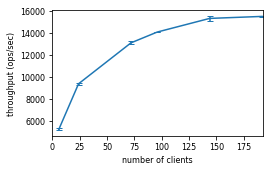

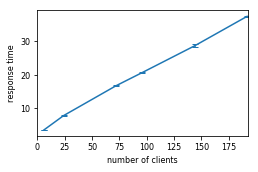

In [52]:
def build_plot(n_clients, avg, std, ylabel):
   
    plt.rc('font', family='serif', serif='Times')
    plt.rc('text', usetex=False)
    plt.rc('xtick', labelsize=8)
    plt.rc('ytick', labelsize=8)
    plt.rc('axes', labelsize=8)

    # width as measured in inkscape
    width = 3.487
    height = width / 1.618

    fig, ax = plt.subplots()
    fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)

    plt.errorbar(n_clients, avg, std, capsize=3)

    ax.set_ylabel(ylabel)
    ax.set_xlabel('number of clients')
    ax.set_xlim(0, n_clients[-1]+1)

    fig.set_size_inches(width, height)
    fig.savefig('./plot.pdf')
    

data = get_plot_data("write-only")
print(data)
build_plot(n_clients=data['n_clients'], avg=data['client_throughput_avg'] , std=data['client_throughput_std'], ylabel='throughput (ops/sec)')

print(data['client_response_time_avg'])
build_plot(n_clients=data['n_clients'], avg=data['client_response_time_avg'] , std=data['client_response_time_std'], ylabel='response time')
